In [1]:
#import libraries
import pandas as pd
import os
import zipfile
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import (
    accuracy_score, 
    recall_score, 
    precision_score, 
    make_scorer, 
    confusion_matrix, 
    ConfusionMatrixDisplay, 
    confusion_matrix,
    r2_score)
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import StandardScaler
import numpy as np

In [2]:
#Downloading dataset from Kaggle
!kaggle datasets download -d ashydv/leads-dataset
#Unzipping the file
zipfile_path = os.getcwd()+'\leads-dataset.zip'
with zipfile.ZipFile(zipfile_path, 'r') as zip_ref:
    zip_ref.extractall(os.getcwd())

#reading the dataset into pandas
df = pd.read_csv(os.getcwd()+'\Leads.csv')
#df = df.dropna(subset=['Lead Quality'])
df.info()
df.describe()

Dataset URL: https://www.kaggle.com/datasets/ashydv/leads-dataset
License(s): unknown
leads-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 37 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Prospect ID                                    9240 non-null   object 
 1   Lead Number                                    9240 non-null   int64  
 2   Lead Origin                                    9240 non-null   object 
 3   Lead Source                                    9204 non-null   object 
 4   Do Not Email                                   9240 non-null   object 
 5   Do Not Call                                    9240 non-null   object 
 6   Converted                                      9240 non-null   int64  
 7   TotalVisits      

,Lead Number,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Asymmetrique Activity Score,Asymmetrique Profile Score
count,9240.000000,9240.000000,9103.000000,9240.000000,9103.000000,5022.000000,5022.000000
mean,617188.435606,0.385390,3.445238,487.698268,2.362820,14.306252,16.344883
std,23405.995698,0.486714,4.854853,548.021466,2.161418,1.386694,1.811395
min,579533.000000,0.000000,0.000000,0.000000,0.000000,7.000000,11.000000
25%,596484.500000,0.000000,1.000000,12.000000,1.000000,14.000000,15.000000
50%,615479.000000,0.000000,3.000000,248.000000,2.000000,14.000000,16.000000
75%,637387.250000,1.000000,5.000000,936.000000,3.000000,15.000000,18.000000
max,660737.000000,1.000000,251.000000,2272.000000,55.000000,18.000000,20.000000


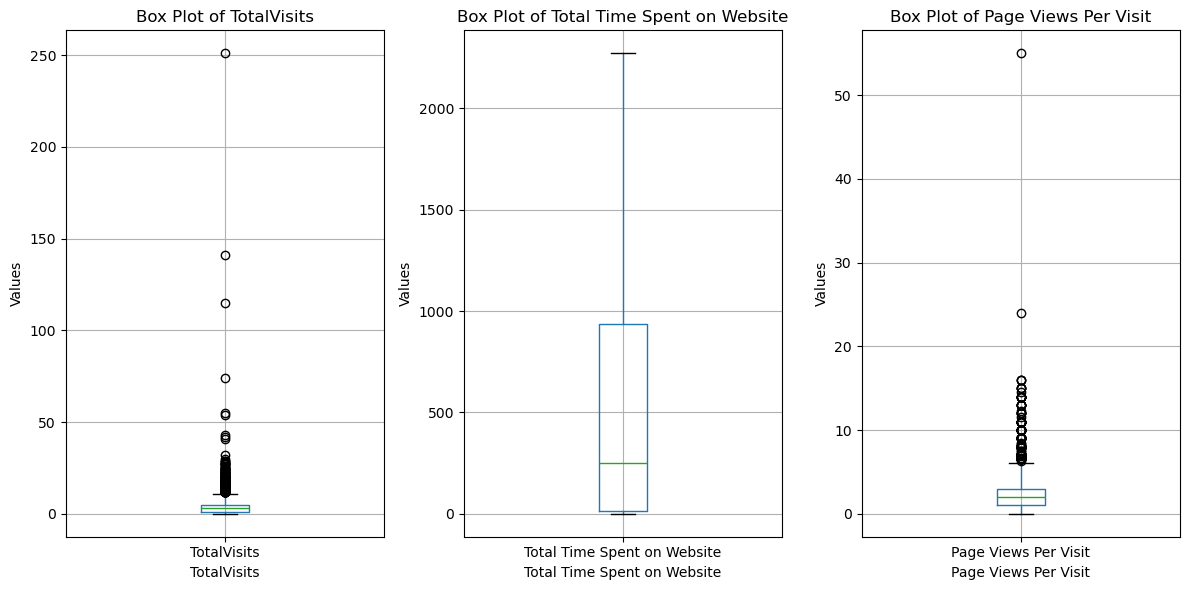

In [3]:
#ploting out boxplot
df2 = df[['TotalVisits','Total Time Spent on Website','Page Views Per Visit']]

fig, axes = plt.subplots(nrows=1, ncols=len(df2.columns), figsize=(12, 6))
for idx, column in enumerate(df2.columns):
    df2.boxplot(column=column, ax=axes[idx])
    axes[idx].set_title(f'Box Plot of {column}')
    axes[idx].set_ylabel('Values')
    axes[idx].set_xlabel(column)

plt.tight_layout()
plt.show()

In [4]:
# drop lead quality
df = df.drop('Lead Quality', axis=1)

#assign different imputation strategy
numerical_imputer = SimpleImputer(strategy='median')
categorical_imputer = SimpleImputer(strategy='most_frequent')
numerical_imputer2 = SimpleImputer(strategy='mean')

#assign variables into 3 different buckets for imputation
numerical_cols = ['TotalVisits','Page Views Per Visit']
numerical_col2 = ['Lead Number','Total Time Spent on Website','Asymmetrique Activity Score','Asymmetrique Profile Score']
categorical_cols = ['Prospect ID', 'Lead Origin', 'Lead Source', 'Do Not Email', 'Do Not Call','Last Activity','Country','Specialization','How did you hear about X Education','What is your current occupation','What matters most to you in choosing a course','Search','Magazine','Newspaper Article','X Education Forums','Newspaper','Digital Advertisement','Through Recommendations','Receive More Updates About Our Courses','Receive More Updates About Our Courses','Tags','Update me on Supply Chain Content','Get updates on DM Content','Lead Profile','City','Asymmetrique Activity Index','Asymmetrique Profile Index','I agree to pay the amount through cheque','A free copy of Mastering The Interview','Last Notable Activity']

df[numerical_cols] = numerical_imputer.fit_transform(df[numerical_cols])
df[numerical_col2] = numerical_imputer2.fit_transform(df[numerical_col2])
df[categorical_cols] = categorical_imputer.fit_transform(df[categorical_cols])

In [5]:
#Removing Outliers
#calculate the first and third quartile for 'TotalVisit' and the Interquartile Range
df2 = df[['TotalVisits','Total Time Spent on Website','Page Views Per Visit']]
Q1_Total_Visits = df2['TotalVisits'].quantile(0.25)
Q3_Total_Visits = df2['TotalVisits'].quantile(0.75)
IQR_total_visits = Q3_Total_Visits - Q1_Total_Visits
print(IQR_total_visits)

4.0


In [6]:
#Identify outliers in the 'TotalVisits' column using the IQR method
outliers_total_visits = df2['TotalVisits'][(df2['TotalVisits'] < (Q1_Total_Visits - 1.5 * IQR_total_visits)) |(df2['TotalVisits'] > (Q3_Total_Visits + 1.5 * IQR_total_visits))]
outliers_total_visits.shape

(267,)

In [7]:
#calculate the first and third quartile for 'TotalVisit' and the Interquartile Range
df2 = df[['TotalVisits','Total Time Spent on Website','Page Views Per Visit']]
Q1_page_view = df2['Page Views Per Visit'].quantile(0.25)
Q3_page_view = df2['Page Views Per Visit'].quantile(0.75)
IQR_page_view = Q3_page_view - Q1_page_view
print(IQR_page_view)

2.0


In [8]:
#Identify outliers in the 'TotalVisits' column using the IQR method
outliers_page_view = df2['Page Views Per Visit'][(df2['Page Views Per Visit'] < (Q1_page_view - 1.5 * IQR_page_view)) |(df2['Page Views Per Visit'] > (Q3_page_view + 1.5 * IQR_page_view))]
outliers_page_view.shape

(360,)

In [9]:
#droping rows that contain outliers 
df_no_outliers = df.drop(outliers_total_visits.index, axis = 0)
df_no_outliers.shape

df_no_outliers = df.drop(outliers_page_view.index, axis = 0)
df = df_no_outliers
df.shape

(8880, 36)

In [10]:
#Convert Categorical to Numbers - Use ColumnTransformer with OneHotEncoder
categorical_cols = ['Prospect ID', 'Lead Origin', 'Lead Source', 'Do Not Email', 'Do Not Call','Last Activity','Country','Specialization','How did you hear about X Education','What is your current occupation','What matters most to you in choosing a course','Search','Magazine','Newspaper Article','X Education Forums','Newspaper','Digital Advertisement','Through Recommendations','Receive More Updates About Our Courses','Receive More Updates About Our Courses','Tags','Update me on Supply Chain Content','Get updates on DM Content','Lead Profile','City','Asymmetrique Activity Index','Asymmetrique Profile Index','I agree to pay the amount through cheque','A free copy of Mastering The Interview','Last Notable Activity']
numerical_cols = ['TotalVisits','Total Time Spent on Website','Lead Number','Page Views Per Visit','Asymmetrique Activity Score','Asymmetrique Profile Score']
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_cols), 
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])


In [11]:
def metrics_output(model,flag=True):
    '''
    model : classifier to predict values of X

    '''
    # Generate predicted values
    y_pred = model.predict(X_test)
    
    # defining an empty list to store train and test results
    score_list=[] 
    
    #Predicting on train and tests
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    
    #Accuracy of the model
    train_acc = model.score(X_train,y_train)
    test_acc = model.score(X_test,y_test)
    
    #Recall of the model
    train_recall = metrics.recall_score(y_train,pred_train)
    test_recall = metrics.recall_score(y_test,pred_test)
    
    #Precision of the model
    train_precision = metrics.precision_score(y_train,pred_train)
    test_precision = metrics.precision_score(y_test,pred_test)
    
    score_list.extend((train_acc,test_acc,train_recall,test_recall,train_precision,test_precision))
        
    # If the flag is set to True then only the following print statements will be dispayed. The default value is set to True.
    if flag == True: 
        print("Accuracy on training set : ",model.score(X_train,y_train))
        print("Accuracy on test set : ",model.score(X_test,y_test))
        print("Recall on training set : ",metrics.recall_score(y_train,pred_train))
        print("Recall on test set : ",metrics.recall_score(y_test,pred_test))
        print("Precision on training set : ",metrics.precision_score(y_train,pred_train))
        print("Precision on test set : ",metrics.precision_score(y_test,pred_test))
    
    return score_list # returning the list with train and test scores

In [12]:
X = df.drop('Converted', axis=1)
y = df.pop('Converted')

X_transformed = preprocessor.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.3, random_state=1, stratify=y)

In [13]:
# Build and train a Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)
rf_estimator_score=metrics_output(rf_model)

Accuracy on training set :  1.0
Accuracy on test set :  0.9174174174174174
Recall on training set :  1.0
Recall on test set :  0.8549172346640701
Precision on training set :  1.0
Precision on test set :  0.9251844046364595


In [ ]:
# Hyperparamter tuning - Choose the type of classifier. 
rf_estimator_tuned = RandomForestClassifier(random_state=1)

# Grid of parameters to choose from
parameters = {"n_estimators": [150,200, 250],
    "min_samples_leaf": np.arange(5, 10),
    "max_features": np.arange(0.2, 0.7, 0.1),
    "max_samples": np.arange(0.3, 0.7, 0.1),
    "max_depth" : [None, 10, 20, 30, 40, 50]
             }

# Choosing precision score as the metric for comparison
scorer = make_scorer(precision_score)

# Run the randomizedSearchCV
rand_obj = RandomizedSearchCV(rf_estimator_tuned, parameters, scoring=scorer, cv=5)
rand_obj = rand_obj.fit(X_train, y_train)

# Choose the best classifier 
rf_estimator_tuned = rand_obj.best_estimator_

# Train the best classifier 
rf_estimator_tuned.fit(X_train, y_train)

# Obtain predicted values from the test set
y_pred_rf_t = rf_estimator_tuned.predict(X_test)
rf_estimator_score=metrics_output(rf_estimator_tuned)

In [ ]:
# Calculate feature importances
feature_importances = rf_estimator_tuned.feature_importances_

# Get the names of the categorical columns after one-hot encoding
categorical_encoder = preprocessor.named_transformers_['cat']
categorical_feature_names = categorical_encoder.get_feature_names_out(input_features=categorical_cols)

# Combine numerical and one-hot encoded categorical feature names
all_feature_names = numerical_cols + list(categorical_feature_names)

# Create a DataFrame to store feature names and their importances
feature_importance_df = pd.DataFrame({'Feature': all_feature_names, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Select the top 20 features by importance
top_20_features = feature_importance_df.head(20)

# Print the top 20 feature importances
print("Top 20 Feature Importances:")

# Plot the top 20 feature importances
plt.figure(figsize=(12, 8))
plt.barh(range(len(top_20_features)), top_20_features['Importance'], align='center')
plt.yticks(range(len(top_20_features)), top_20_features['Feature'])
plt.xlabel('Feature Importance')
plt.title('Top 20 Random Forest Feature Importance')
plt.gca().invert_yaxis()
plt.show()

In [ ]:
predictions = rf_estimator_tuned.predict(X_transformed)
probability = rf_estimator_tuned.predict_proba(X_transformed)
df['Predictions'] = predictions
df['Probability'] = probability[:,1]
df.to_csv('random_forest_predictions.csv', index=False)